---
# <center>Dataset creation

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from tqdm import tqdm

#################################
# Dataset and Data Preparation  #
#################################

class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None, root="./datasets/speechcommand", download=True):
        super().__init__(root=root, download=download)
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.join(self._path, line.strip()) for line in f]
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


class InMemorySpeechCommands(Dataset):
    def __init__(self, subset="training", fixed_length=16000):
        """
        Args:
          subset: One of "training", "validation", "testing".
          fixed_length: The desired number of audio samples per clip.
        """
        self.fixed_length = fixed_length
        self.dataset = SubsetSC(subset=subset, root="./datasets/speechcommand", download=True)
        self.data = []
        self.labels = []
        
        # Build label index from the dataset's actual folder location
        dataset_root = self.dataset._path  # use the path used by the dataset
        all_labels = [
            d for d in os.listdir(dataset_root)
            if os.path.isdir(os.path.join(dataset_root, d)) and d != '_background_noise_'
        ]
        self.label_set = sorted(all_labels)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.label_set)}
        print(f"Found {len(self.label_set)} labels: {self.label_set}")
        
        # Load all samples into memory (resample, pad/trim)
        for waveform, sample_rate, label, *_ in tqdm(self.dataset, desc=f"Loading {subset} data", leave=False):
            if sample_rate != 16000:
                resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
                waveform = resampler(waveform)
            waveform = waveform.squeeze(0)  # Remove channel dimension if exists
            if waveform.size(0) > fixed_length:
                waveform = waveform[:fixed_length]
            elif waveform.size(0) < fixed_length:
                waveform = F.pad(waveform, (0, fixed_length - waveform.size(0)))
            self.data.append(waveform)
            try:
                self.labels.append(self.label_to_idx[label])
            except KeyError:
                # If a label is encountered that's not in our mapping, add it
                # (or alternatively, you could skip it or raise an error)
                new_idx = len(self.label_to_idx)
                print(f"New label found: {label}. Assigning new index {new_idx}")
                self.label_to_idx[label] = new_idx
                self.label_set.append(label)
                self.labels.append(new_idx)
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.fixed_length, self.labels[idx]



---
# <center>Model Architecture

In [2]:
class MaskedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride,
                              padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.padding = padding
        self.dilation = dilation
        self.stride = stride
        self.kernel_size = kernel_size

    def forward(self, x, length):
        max_length = x.size(2)
        length = torch.div(((length + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1).float() + self.stride),
                           self.stride, rounding_mode='floor').long()
        mask = torch.arange(max_length, device=x.device)[None, :] < length[:, None]
        x = x * mask.unsqueeze(1)
        x = self.conv(x)
        return x, length

class JasperBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, dropout=0.0, residual=False):
        super().__init__()
        self.mconv = nn.ModuleList([
            MaskedConv1d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=in_channels, bias=False),
            MaskedConv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(out_channels)
        ])
        self.res = None
        if residual:
            self.res = nn.ModuleList([
                nn.ModuleList([
                    MaskedConv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm1d(out_channels)
                ])
            ])
        self.mout = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout)
        )

    def forward(self, x, length):
        residual = x
        res_length = length
        out = x
        out_length = length
        for layer in self.mconv:
            if isinstance(layer, MaskedConv1d):
                out, out_length = layer(out, out_length)
            else:
                out = layer(out)
        if self.res:
            for res_layer_list in self.res:
                res = residual
                for layer in res_layer_list:
                    if isinstance(layer, MaskedConv1d):
                        res, _ = layer(res, res_length)
                    else:
                        res = layer(res)
                residual = res
        if self.res is not None:
            out = out + residual
        out = self.mout(out)
        return out, out_length

class ConvASREncoder(nn.Module):
    def __init__(self, in_channels, blocks_params):
        super().__init__()
        layers = [JasperBlock(**params) for params in blocks_params]
        self.encoder = nn.Sequential(*layers)
        self.in_channels = in_channels

    def forward(self, x, length):
        for layer in self.encoder:
            x, length = layer(x, length)
        return x, length

class AudioToMFCCPreprocessor(nn.Module):
    def __init__(self, sample_rate=16000, n_mels=64, n_mfcc=64, n_fft=512, hop_length=160, f_min=0, f_max=8000):
        super().__init__()
        self.featurizer = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
                "n_fft": n_fft,
                "n_mels": n_mels,
                "hop_length": hop_length,
                "f_min": f_min,
                "f_max": f_max,
            },
        )

    def forward(self, x, length):
        with torch.no_grad():
            x = self.featurizer(x)
        return x, length

class ConvASRDecoderClassification(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.pooling = nn.AdaptiveAvgPool1d(output_size=1)
        self.decoder_layers = nn.Sequential(
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.pooling(x)
        x = x.squeeze(2)
        x = self.decoder_layers(x)
        return x

class TopKClassificationAccuracy(nn.Module):
    def __init__(self, k=(1,)):
        super().__init__()
        self.k = k

    def forward(self, logits, targets):
        with torch.no_grad():
            maxk = max(self.k)
            batch_size = targets.size(0)
            _, pred = logits.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(targets.view(1, -1).expand_as(pred))
            res = []
            for k in self.k:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res[0] if len(res) == 1 else res

class EncDecClassificationModel(nn.Module):
    def __init__(self, num_classes, sample_rate=16000, n_mels=64, n_mfcc=64, n_fft=512, hop_length=160, f_min=0, f_max=8000):
        super().__init__()
        self.preprocessor = AudioToMFCCPreprocessor(
            sample_rate=sample_rate, n_mels=n_mels, n_mfcc=n_mfcc,
            n_fft=n_fft, hop_length=hop_length, f_min=f_min, f_max=f_max)
        blocks_params = [
            {"in_channels": n_mfcc, "out_channels": 128, "kernel_size": 11, "stride": 1, "padding": 5, "dilation": 1, "dropout": 0.0, "residual": False},
            {"in_channels": 128, "out_channels": 64, "kernel_size": 13, "stride": 1, "padding": 6, "dilation": 1, "dropout": 0.0, "residual": True},
            {"in_channels": 64, "out_channels": 64, "kernel_size": 15, "stride": 1, "padding": 7, "dilation": 1, "dropout": 0.0, "residual": True},
            {"in_channels": 64, "out_channels": 64, "kernel_size": 17, "stride": 1, "padding": 8, "dilation": 1, "dropout": 0.0, "residual": True},
            {"in_channels": 64, "out_channels": 128, "kernel_size": 29, "stride": 1, "padding": 28, "dilation": 2, "dropout": 0.0, "residual": False},
            {"in_channels": 128, "out_channels": 128, "kernel_size": 1, "stride": 1, "padding": 0, "dilation": 1, "dropout": 0.0, "residual": False},
        ]
        self.encoder = ConvASREncoder(in_channels=n_mfcc, blocks_params=blocks_params)
        self.decoder = ConvASRDecoderClassification(in_features=128, num_classes=num_classes)
        self.loss = nn.CrossEntropyLoss()
        self._accuracy = TopKClassificationAccuracy()

    def forward(self, x, length, y=None):
        x, length = self.preprocessor(x, length)
        x, length = self.encoder(x, length)
        logits = self.decoder(x)
        if y is not None:
            loss = self.loss(logits, y)
            acc = self._accuracy(logits, y)
            return loss, acc, logits
        else:
            return logits

    def predict(self, x, length):
        with torch.no_grad():
            logits = self.forward(x, length)
            return torch.argmax(logits, dim=-1)


---
# <center>Training

In [5]:
import os
import pickle

def get_datasets(fixed_length=16000):
    train_pickle = "./datasets/train_dataset.pkl"
    val_pickle = "./datasets/val_dataset.pkl"
    
    if os.path.exists(train_pickle) and os.path.exists(val_pickle):
        print("Loading datasets from pickle files...")
        with open(train_pickle, "rb") as f:
            train_dataset = pickle.load(f)
        with open(val_pickle, "rb") as f:
            val_dataset = pickle.load(f)
    else:
        print("Creating datasets and saving to pickle...")
        train_dataset = InMemorySpeechCommands(subset="training", fixed_length=fixed_length)
        val_dataset = InMemorySpeechCommands(subset="validation", fixed_length=fixed_length)
        # Save datasets to pickle files
        os.makedirs(os.path.dirname(train_pickle), exist_ok=True)
        with open(train_pickle, "wb") as f:
            pickle.dump(train_dataset, f)
        with open(val_pickle, "wb") as f:
            pickle.dump(val_dataset, f)
    
    return train_dataset, val_dataset

# Usage:
train_dataset, val_dataset = get_datasets(fixed_length=16000)
num_classes = len(train_dataset.label_set)

Creating datasets and saving to pickle...
Found 35 labels: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


Found 35 labels: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


Checkpoint saved to checkpoints/classification_experiment/checkpoint_0_1654_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.3126 and val acc: 90.68%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_0_1654.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [1/50] Train Loss: 0.7088 | Train Acc: 80.80% | Val Loss: 0.3126 | Val Acc: 90.68%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_1_3308_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1976 and val acc: 93.89%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_1_3308.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [2/50] Train Loss: 0.2889 | Train Acc: 91.37% | Val Loss: 0.1976 | Val Acc: 93.89%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_2_4962_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1731 and val acc: 94.48%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_2_4962.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [3/50] Train Loss: 0.2375 | Train Acc: 92.74% | Val Loss: 0.1731 | Val Acc: 94.48%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_3_6616_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1435 and val acc: 95.63%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_3_6616.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [4/50] Train Loss: 0.2053 | Train Acc: 93.65% | Val Loss: 0.1435 | Val Acc: 95.63%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_4_8270_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1307 and val acc: 95.96%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_4_8270.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [5/50] Train Loss: 0.1836 | Train Acc: 94.39% | Val Loss: 0.1307 | Val Acc: 95.96%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_5_9924_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1306 and val acc: 95.80%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_5_9924.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [6/50] Train Loss: 0.1702 | Train Acc: 94.75% | Val Loss: 0.1306 | Val Acc: 95.80%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_6_11578_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1036 and val acc: 96.77%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_6_11578.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [7/50] Train Loss: 0.1552 | Train Acc: 95.18% | Val Loss: 0.1036 | Val Acc: 96.77%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_7_13232_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0958 and val acc: 97.10%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_7_13232.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [8/50] Train Loss: 0.1443 | Train Acc: 95.51% | Val Loss: 0.0958 | Val Acc: 97.10%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_8_14886_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0909 and val acc: 97.11%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_8_14886.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [9/50] Train Loss: 0.1350 | Train Acc: 95.76% | Val Loss: 0.0909 | Val Acc: 97.11%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_9_16540.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [10/50] Train Loss: 0.1258 | Train Acc: 96.07% | Val Loss: 0.0928 | Val Acc: 96.99%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_10_18194_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0759 and val acc: 97.73%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_10_18194.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [11/50] Train Loss: 0.1193 | Train Acc: 96.24% | Val Loss: 0.0759 | Val Acc: 97.73%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_11_19848_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0749 and val acc: 97.74%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_11_19848.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [12/50] Train Loss: 0.1109 | Train Acc: 96.54% | Val Loss: 0.0749 | Val Acc: 97.74%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_12_21502_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0728 and val acc: 97.72%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_12_21502.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [13/50] Train Loss: 0.1073 | Train Acc: 96.57% | Val Loss: 0.0728 | Val Acc: 97.72%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_13_23156_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0610 and val acc: 98.25%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_13_23156.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [14/50] Train Loss: 0.1005 | Train Acc: 96.79% | Val Loss: 0.0610 | Val Acc: 98.25%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_14_24810_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0555 and val acc: 98.23%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_14_24810.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [15/50] Train Loss: 0.0950 | Train Acc: 97.00% | Val Loss: 0.0555 | Val Acc: 98.23%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_15_26464.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [16/50] Train Loss: 0.0903 | Train Acc: 97.08% | Val Loss: 0.0563 | Val Acc: 98.15%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_16_28118.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [17/50] Train Loss: 0.0877 | Train Acc: 97.18% | Val Loss: 0.0579 | Val Acc: 98.05%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_17_29772_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0524 and val acc: 98.30%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_17_29772.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [18/50] Train Loss: 0.0838 | Train Acc: 97.30% | Val Loss: 0.0524 | Val Acc: 98.30%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_18_31426_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0507 and val acc: 98.45%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_18_31426.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [19/50] Train Loss: 0.0789 | Train Acc: 97.45% | Val Loss: 0.0507 | Val Acc: 98.45%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_19_33080_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0462 and val acc: 98.45%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_19_33080.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [20/50] Train Loss: 0.0784 | Train Acc: 97.48% | Val Loss: 0.0462 | Val Acc: 98.45%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_20_34734_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0429 and val acc: 98.60%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_20_34734.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [21/50] Train Loss: 0.0739 | Train Acc: 97.60% | Val Loss: 0.0429 | Val Acc: 98.60%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_21_36388_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0402 and val acc: 98.83%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_21_36388.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [22/50] Train Loss: 0.0723 | Train Acc: 97.69% | Val Loss: 0.0402 | Val Acc: 98.83%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_22_38042.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [23/50] Train Loss: 0.0693 | Train Acc: 97.80% | Val Loss: 0.0431 | Val Acc: 98.61%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_23_39696_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0396 and val acc: 98.72%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_23_39696.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [24/50] Train Loss: 0.0685 | Train Acc: 97.79% | Val Loss: 0.0396 | Val Acc: 98.72%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_24_41350_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0380 and val acc: 98.78%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_24_41350.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [25/50] Train Loss: 0.0659 | Train Acc: 97.88% | Val Loss: 0.0380 | Val Acc: 98.78%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_25_43004_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0365 and val acc: 98.85%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_25_43004.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [26/50] Train Loss: 0.0625 | Train Acc: 97.99% | Val Loss: 0.0365 | Val Acc: 98.85%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_26_44658.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [27/50] Train Loss: 0.0628 | Train Acc: 97.98% | Val Loss: 0.0395 | Val Acc: 98.76%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_27_46312_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0327 and val acc: 98.91%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_27_46312.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [28/50] Train Loss: 0.0607 | Train Acc: 98.08% | Val Loss: 0.0327 | Val Acc: 98.91%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_28_47966_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0282 and val acc: 99.14%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_28_47966.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [29/50] Train Loss: 0.0573 | Train Acc: 98.20% | Val Loss: 0.0282 | Val Acc: 99.14%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_29_49620.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [30/50] Train Loss: 0.0577 | Train Acc: 98.15% | Val Loss: 0.0339 | Val Acc: 98.91%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_30_51274.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [31/50] Train Loss: 0.0545 | Train Acc: 98.27% | Val Loss: 0.0313 | Val Acc: 98.99%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_31_52928.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [32/50] Train Loss: 0.0510 | Train Acc: 98.38% | Val Loss: 0.0354 | Val Acc: 98.80%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_32_54582.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [33/50] Train Loss: 0.0526 | Train Acc: 98.34% | Val Loss: 0.0294 | Val Acc: 99.11%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_33_56236.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [34/50] Train Loss: 0.0496 | Train Acc: 98.40% | Val Loss: 0.0316 | Val Acc: 99.07%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_34_57890.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [35/50] Train Loss: 0.0515 | Train Acc: 98.35% | Val Loss: 0.0282 | Val Acc: 99.18%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_35_59544_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0135 and val acc: 99.73%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_35_59544.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [36/50] Train Loss: 0.0319 | Train Acc: 99.09% | Val Loss: 0.0135 | Val Acc: 99.73%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_36_61198_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0134 and val acc: 99.66%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_36_61198.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [37/50] Train Loss: 0.0279 | Train Acc: 99.21% | Val Loss: 0.0134 | Val Acc: 99.66%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_37_62852_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0119 and val acc: 99.71%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_37_62852.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [38/50] Train Loss: 0.0259 | Train Acc: 99.28% | Val Loss: 0.0119 | Val Acc: 99.71%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_38_64506_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0114 and val acc: 99.73%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_38_64506.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [39/50] Train Loss: 0.0256 | Train Acc: 99.29% | Val Loss: 0.0114 | Val Acc: 99.73%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_39_66160_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0106 and val acc: 99.73%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_39_66160.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [40/50] Train Loss: 0.0241 | Train Acc: 99.31% | Val Loss: 0.0106 | Val Acc: 99.73%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_40_67814_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0100 and val acc: 99.76%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_40_67814.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [41/50] Train Loss: 0.0237 | Train Acc: 99.28% | Val Loss: 0.0100 | Val Acc: 99.76%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_41_69468_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0084 and val acc: 99.80%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_41_69468.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [42/50] Train Loss: 0.0225 | Train Acc: 99.34% | Val Loss: 0.0084 | Val Acc: 99.80%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_42_71122.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [43/50] Train Loss: 0.0211 | Train Acc: 99.36% | Val Loss: 0.0100 | Val Acc: 99.75%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_43_72776_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0080 and val acc: 99.77%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_43_72776.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [44/50] Train Loss: 0.0218 | Train Acc: 99.34% | Val Loss: 0.0080 | Val Acc: 99.77%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_44_74430.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [45/50] Train Loss: 0.0206 | Train Acc: 99.36% | Val Loss: 0.0102 | Val Acc: 99.71%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_45_76084.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [46/50] Train Loss: 0.0199 | Train Acc: 99.42% | Val Loss: 0.0097 | Val Acc: 99.75%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_46_77738_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0072 and val acc: 99.80%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_46_77738.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [47/50] Train Loss: 0.0191 | Train Acc: 99.44% | Val Loss: 0.0072 | Val Acc: 99.80%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_47_79392_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0068 and val acc: 99.85%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_47_79392.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [48/50] Train Loss: 0.0187 | Train Acc: 99.46% | Val Loss: 0.0068 | Val Acc: 99.85%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_48_81046.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [49/50] Train Loss: 0.0184 | Train Acc: 99.45% | Val Loss: 0.0070 | Val Acc: 99.81%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_49_82700_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0057 and val acc: 99.85%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_49_82700.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [50/50] Train Loss: 0.0182 | Train Acc: 99.47% | Val Loss: 0.0057 | Val Acc: 99.85%


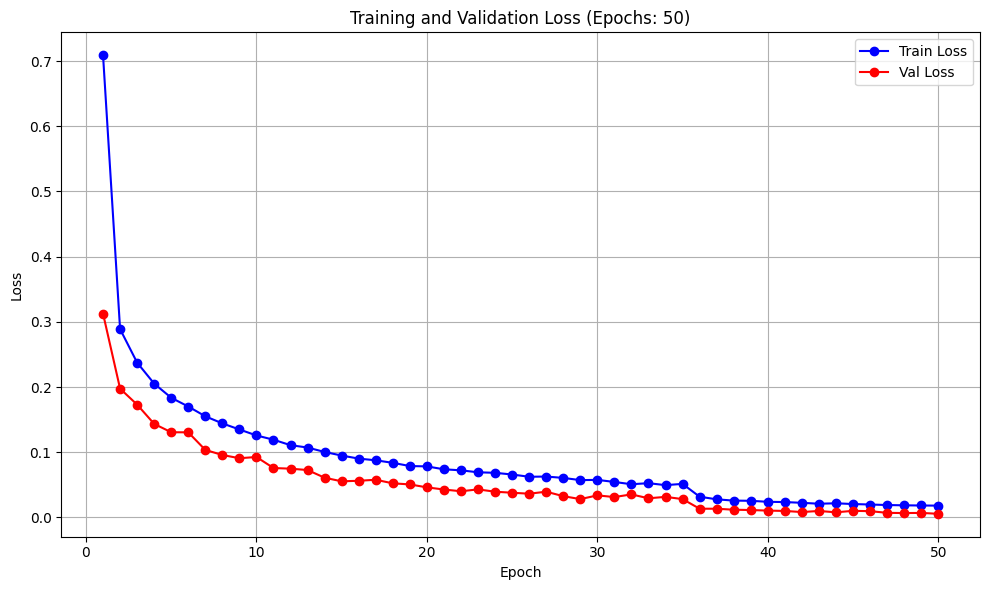

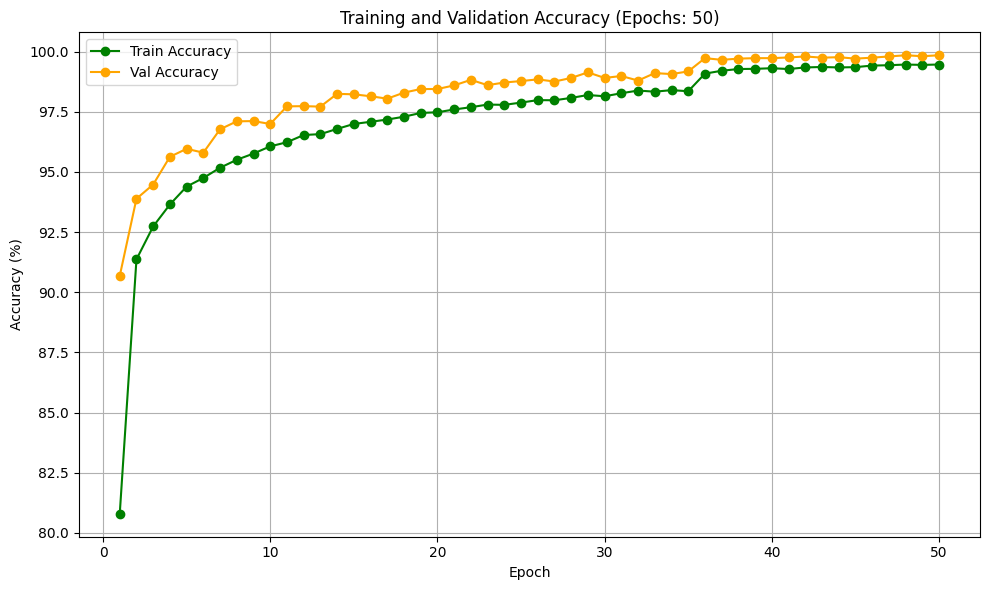

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from training_utils import run_training_classification

# Configuration
experiment_name = "classification_experiment"
num_epochs = 50
batch_size = 64
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = EncDecClassificationModel(num_classes=num_classes, sample_rate=16000)

# Run training using the new classification training pipeline with checkpoint_frequency.
# To save every 50 steps, set checkpoint_frequency=50.
# To save only at the end of each epoch, set checkpoint_frequency=None.
train_losses, train_accuracies, val_losses, val_accuracies, step_history = run_training_classification(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer_class=optim.Adam,
    optimizer_params={'lr': learning_rate},
    scheduler_class=optim.lr_scheduler.ReduceLROnPlateau,  # use a scheduler if needed
    scheduler_params={'mode': 'min', 'factor': 0.5, 'patience': 5},
    num_epochs=num_epochs,
    device=device,
    batch_size=batch_size,
    num_workers=4,
    resume_training=False,
    experiment_name=experiment_name,
    checkpoint_frequency=None  # set to None to save only once per epoch
)

# Optionally, save the training history to a JSON file (including step-level details)
history = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "step_history": step_history
}
with open(f"checkpoints/{experiment_name}/training_history.json", "w") as f:
    json.dump(history, f, indent=4)

# --- Plotting the Metrics ---

# Plot loss curves (per epoch)
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss (Epochs: {num_epochs})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy curves (per epoch)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green', marker='o')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training and Validation Accuracy (Epochs: {num_epochs})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
